# Resonance 1 fr and 1/Qi vs T

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys
import os

sys.path.append('..')
import irdetection.analysis.fitting.models as md
from irdetection.analysis.fitting.FitAPI import Fitter
from irdetection.analysis.fitting.models import Model
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font
from irdetection.graphics.plots import plot
from irdetection.graphics.palettes import QSciencePalette, QScienceTypography

In [2]:


def S21_model(f: np.ndarray, f0: float, phi: float, Qt: float, Qc: float, A: float, B: float, C: float, D: float, K: float, fmin: float) -> np.ndarray:
    return (A+B*(f-fmin) + C*(f-fmin)**2 + D*(f-fmin)**3) + K * np.abs((1 - (Qt/np.abs(Qc))*np.exp(1j*phi)/(1 + 2j*Qt*((f-fmin) - f0)/fmin)))
# 
# Estimate the initial guess of Qt
def peak_width(datax, datay):
    half_height_value = np.min(datay) + (np.max(datay) - np.min(datay)) / np.sqrt(2)
    hits = []
    above = datay[0] > half_height_value
    for i in range(1, len(datay)):
        new_above = datay[i] > half_height_value
        if new_above != above: 
            hits.append((datax[i] + datax[i-1]) / 2)
            above = new_above
    return abs(hits[-1] - hits[0])

result_fr = []
err_fr = []
result_Qi = []
err_Qi = []
T = []

f = []
y = []
for i in range(40, 116, 2):
    path = '../Data/fit_test/gap run12/Q_res' +str(i) +'.txt'
    data = np.loadtxt(path, delimiter=',', skiprows=0)
    f.append(data[:,0])
    I = data[:,1]
    Q = data[:,2]
    # Convert to module
    y.append(np.sqrt(I**2 + Q**2))
    T.append(410 - 10*((i-40)/2))

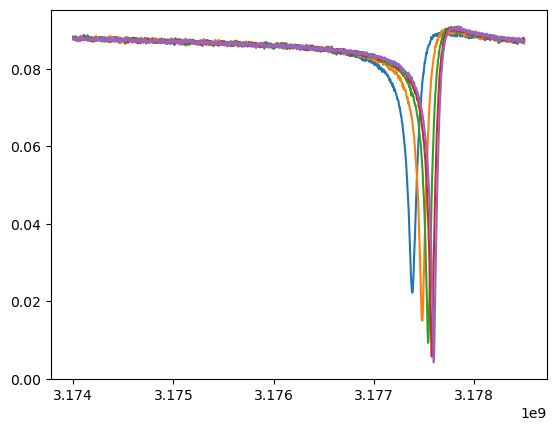

In [3]:
for i in range(5):
    plt.plot(f[i*3], y[i*3])
plt.show()

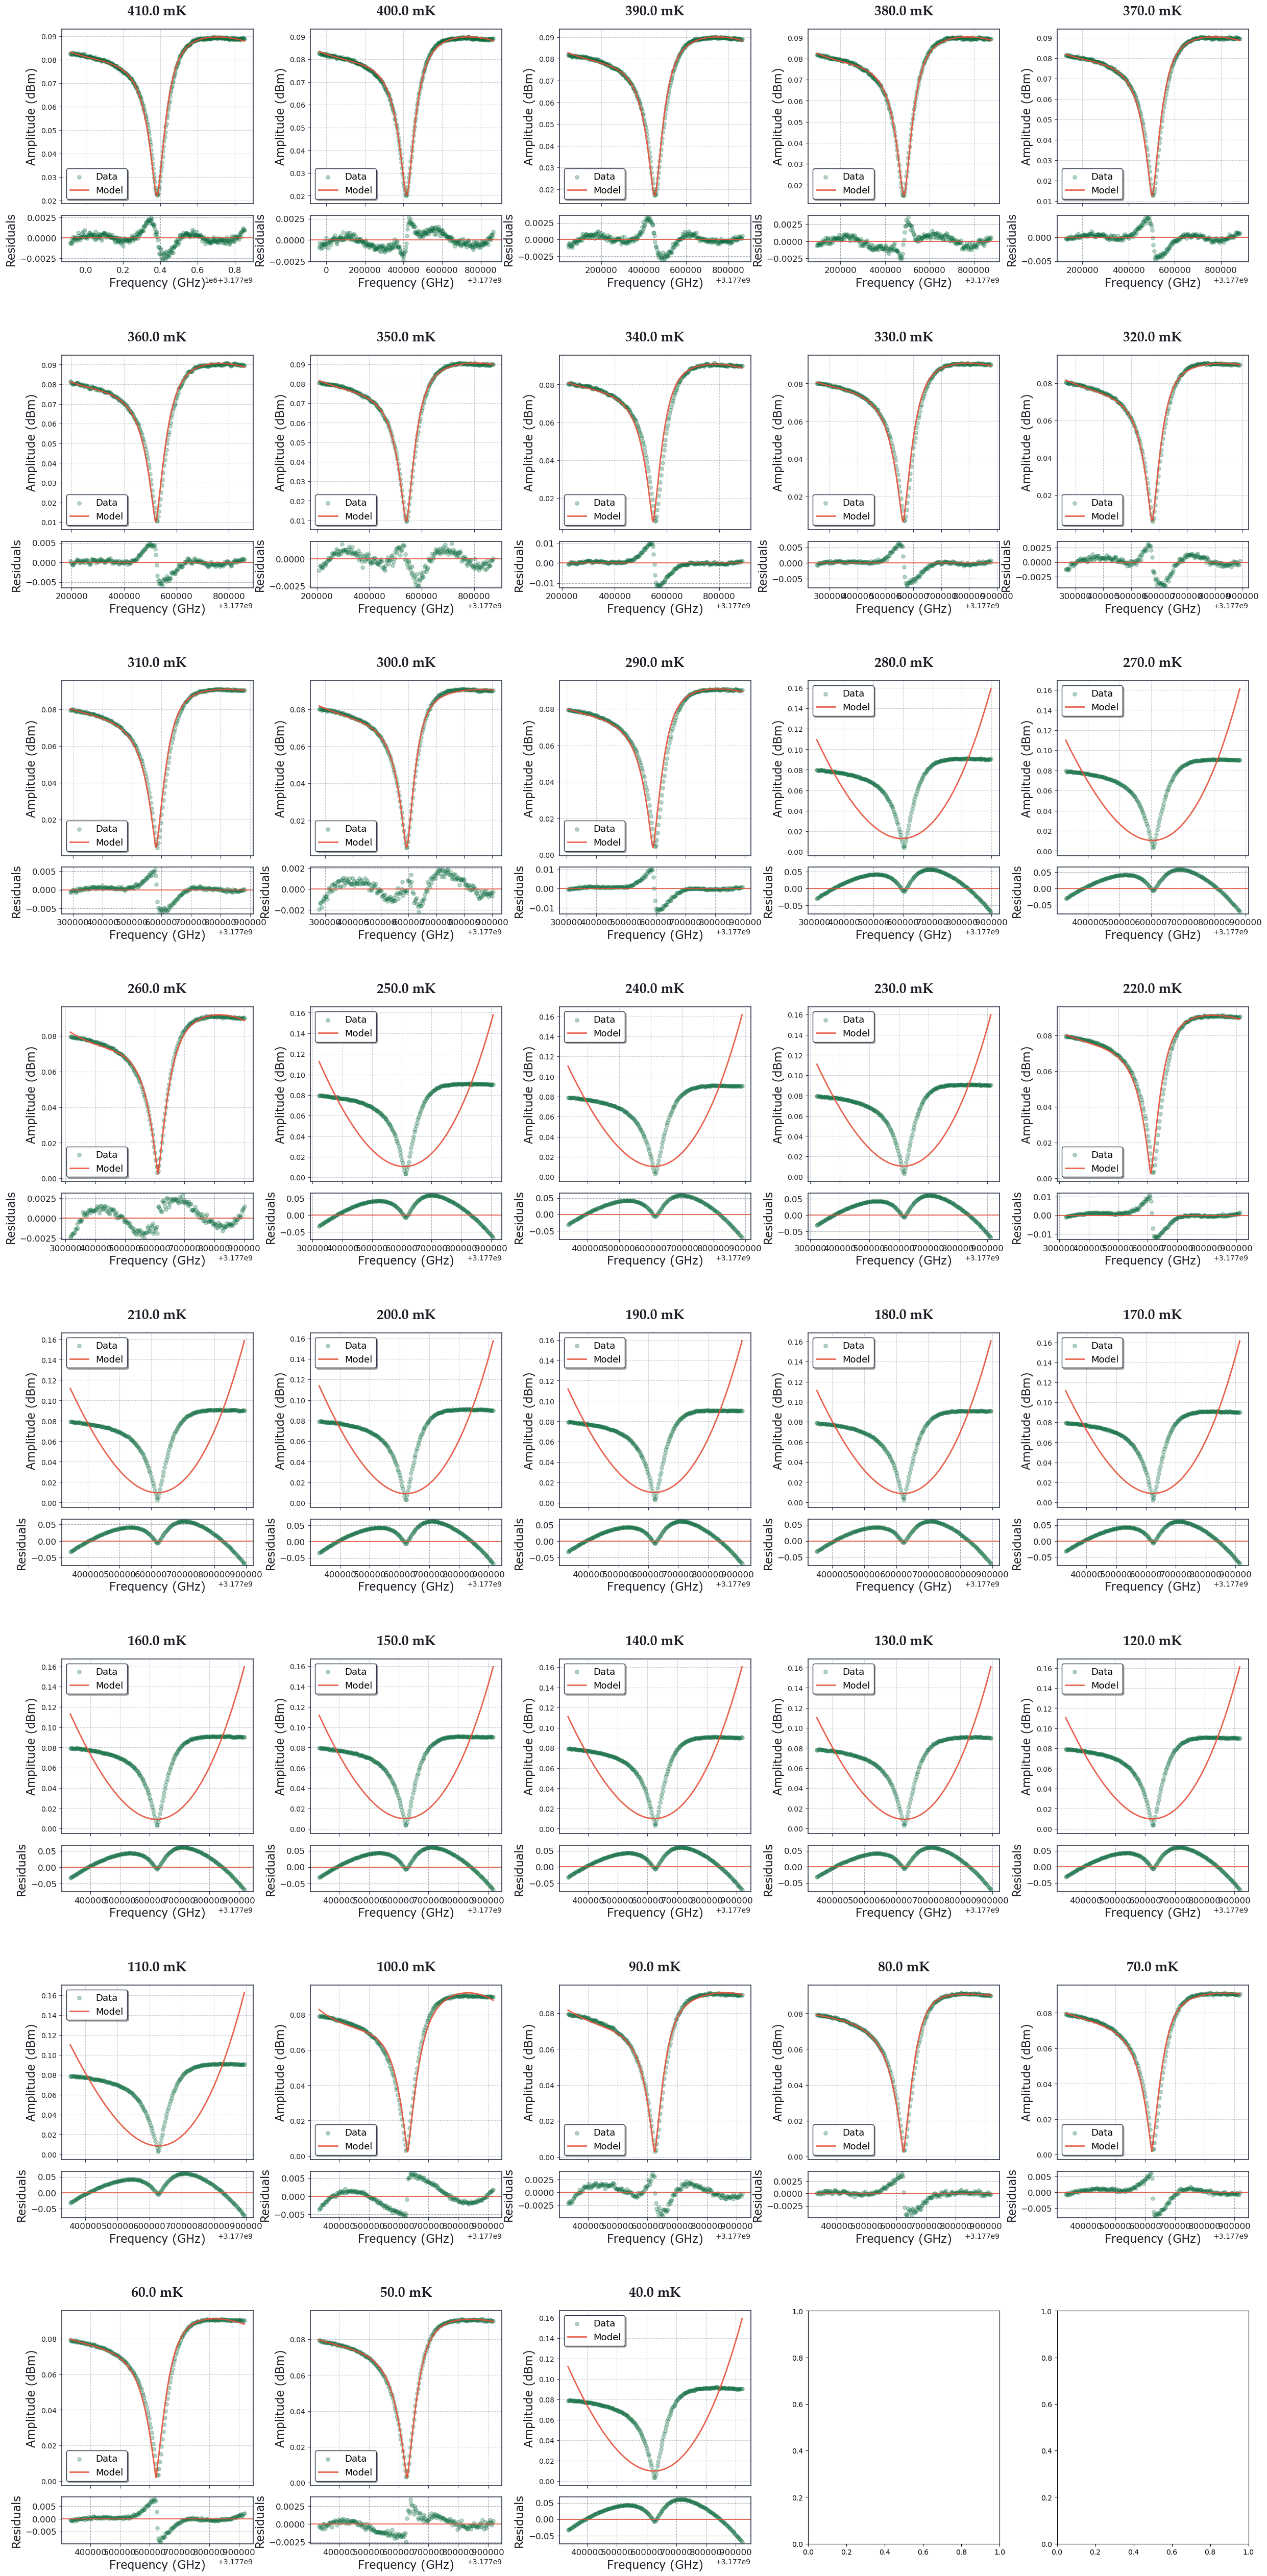

[3177393480.7801414, 3177426286.5747614, 3177461564.7691827, 3177494821.4044995, 3177513534.023039, 3177531814.7026515, 3177551360.7599382, 3177559543.77373, 3177574865.8257375, 3177585806.1767755, 3177594921.8983, 3177604039.6094613, 3177603107.868894, 3177633020.301484, 3177633345.3140874, 3177618806.2281995, 3177640794.272969, 3177641627.0309954, 3177644583.6059318, 3177622768.343518, 3177645288.792948, 3177647604.083592, 3177649857.0213075, 3177648961.7912154, 3177649793.3291717, 3177651173.574975, 3177652200.831603, 3177652484.5029726, 3177650495.0993915, 3177652703.2699747, 3177650618.6681457, 3177636987.495079, 3177633401.7678037, 3177640648.656282, 3177635557.7824974, 3177634701.727821, 3177641539.765309, 3177654433.3629484]
[150444.13299468768, 146120.55312200307, 159822.84320651682, 178147.256078621, 298762.72651865636, 457935.20317955565, 292136.81170384644, 680889.3297408771, 668695.9818738733, 420522.39114244364, 14128.359475693693, 408716.86474862974, 1569006.5657972104, 

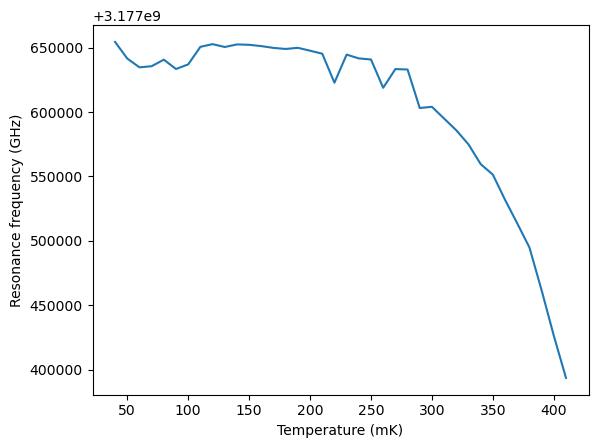

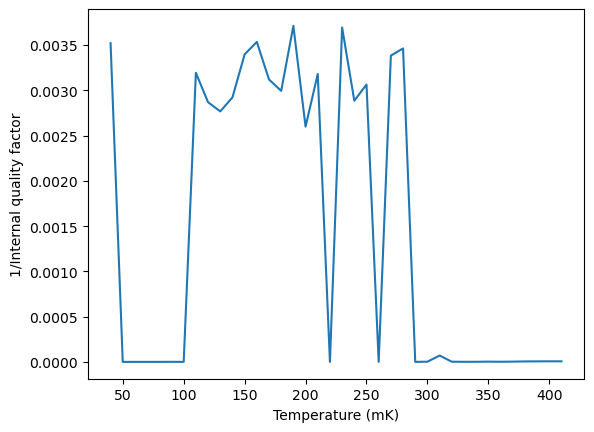

In [3]:
#empty result and err arrays
result_fr = []
err_fr = []
result_Qi = []
err_Qi = []
result_Qt = []
result_Qc = []

initial_guess = {
    "f0": 17000, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    }

param_limits = {
    "Qc": (1e2, 1e7),
    "Qt": (1e2, 1e7),
    #'phi': (-20, 20),
    #'f0': (-1e6, 1e6),
    }

nof_peaks = len(T)
nrows = (nof_peaks + 4) // 5

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})
row_iter = 0
col_iter = 0
pippo = 0

for i in range(0, len(T)):
    f_i = f[int(i)]
    y_i = y[int(i)]
    
    fmin = f_i[np.argmin(y_i)]
    initial_guess['fmin'] = fmin
    fwhm = peak_width(f_i, -y_i)
    
    mask = (f_i > fmin - 7 * fwhm) & (f_i < fmin + 7 * fwhm)
    f_i = f_i[mask]
    y_i = y_i[mask]

    # Estimate the initial guess of Qt
    Qt_guess = fmin / peak_width(f_i, -y_i)
    initial_guess['Qt'] = Qt_guess

    # Estimate the initial guess of K
    initial_guess['K'] = (np.max(y_i) - np.min(y_i)) * initial_guess['Qc'] / initial_guess['Qt']
    #print(f"Initial guess: {initial_guess}")

    fit_data = np.column_stack((f_i, y_i))
    fitter = Fitter(model_function=md.resonance_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                    data=fit_data, 
                    loss_manager=LeastSquares,
                    params_initial_guess=initial_guess,
                    params_range=param_limits
                    )
    
    # searcher = ResonancePeakSearcher(version="T")
    # result = fitter.fit(searcher=searcher)

    # fitter.model.set_fixed_params({"fmin": fmin})
    result = fitter.fit()
    result_dict = result.values.to_dict()
    err_dict = result.errors.to_dict()
    
    result_fr.append(result_dict['f0'] + fmin)#searcher.params['fmin'])
    err_fr.append(err_dict['f0'])
    
    result_Qi.append(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1))
    Qt = result_dict['Qt']
    Qc = result_dict['Qc']
    err_Qi.append(np.sqrt((err_dict['Qt'] * Qt**-2)**2 + (err_dict['Qc'] * Qc**-2)**2) * ((1/Qt-1/Qc)**-2))
    
    result_Qc.append(result_dict['Qc'])
    result_Qt.append(result_dict['Qt'])
    # print("Q_res" + str(i*2 + 40))
    # print("Q_i: " + str(abs((1/result_dict['Qt']-1/result_dict['Qc'])**-1)))
    result_dict['fmin'] = fmin #searcher.params['fmin']
    #print(f"Result: {result_dict}")
    
    plot_fit(fit_data, md.resonance_model, result_dict,
                     title=f'{T[i]} mK', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=QSciencePalette, 
                     typography=QScienceTypography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
    
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    
    
plt.show()

print(result_fr)
print(result_Qi)
print(T) 

plt.plot(T, result_fr, linestyle='-', label='fr')
#plt.errorbar(T, result_fr, err_fr, linestyle='-', label='fr')
plt.ylabel('Resonance frequency (GHz)')
plt.xlabel('Temperature (mK)')
plt.show()

Qi_plot = 1/np.array(result_Qi)
err_Qi_plot = err_Qi*np.array(result_Qi)**-2

plt.plot(T, Qi_plot, linestyle='-', label='Qi')
# plt.plot(T, result_Qt, linestyle='-', color='r')
# plt.plot(T, result_Qc, linestyle='-', color='g')
#plt.errorbar(T, Qi_plot, err_Qi_plot, linestyle='-', label='Qi')
plt.ylabel('1/Internal quality factor')
plt.xlabel('Temperature (mK)')
plt.show()

Result: {'D0_k': 3.7134283064040425, 'w': np.float64(3177641828.5254445), 'Q0': np.float64(1861716.9554596313), 'a': 0.8}
Result D0 (meV): 0.3204338173630272 +- 0.0023889955620808646
T_C (K): 2.109902446820479 +- 0.0157303858355472


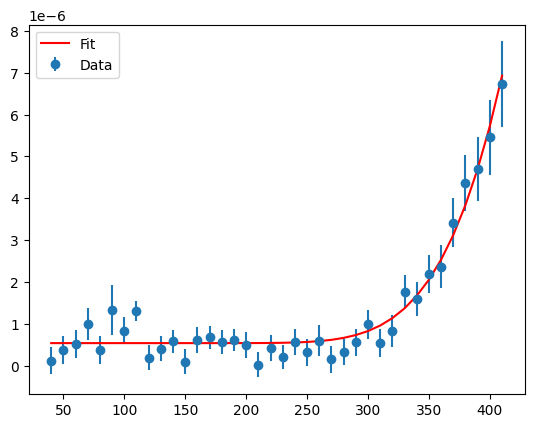

In [12]:
from scipy import constants as cs
mask = (np.array(T)<250.0)
mask2= (np.array(T)<150)
_Q0 = np.mean(np.array(Qi_plot)[mask])
w = np.mean(np.array(result_fr)[mask2])

initial_guess = {
    "Q0": _Q0**-1,
    "a": 0.8,
    "D0_k": 3.67,
    "w": w
    }

fit_data = np.column_stack((T, Qi_plot))
fitter = Fitter(model_function=md.qi_factor_model, 
                    param_names=["Q0", "a", "D0_k", "w"], 
                    data=fit_data, 
                    yerr=err_Qi_plot,
                    loss_function=LeastSquares,
                    params_initial_guess=initial_guess)

fitter.model.set_active_params(["D0_k"])
result = fitter.fit()

result_dict = result.values.to_dict()
result_dict['w'] = w
result_dict['Q0'] = _Q0**-1
result_dict['a'] = initial_guess['a']
err_dict = result.errors.to_dict()

print(f"Result: {result_dict}")
print(f"Result D0 (meV): {result_dict["D0_k"]*cs.k/(1.6e-22)} +- {err_dict['D0_k']*cs.k/(1.6e-22)}")
T_C = 2/3.52 * result_dict["D0_k"]
print(f"T_C (K): {T_C} +- {2/3.52 * err_dict['D0_k']}")
grapher = fitPlotter(result_dict, T, Qi_plot, md.qi_factor_model, err_y = err_Qi_plot)
grapher.simple_plot()